Base directory: results/GIB_MULTIRUN
Algorithms to analyze: ['nsga2']
Using scorer: distance

Searching for: results/GIB_MULTIRUN_nsga2_run*
  ✓ Found run 8: score=115306.18
  ✓ Found run 7: score=115856.18
  ✓ Found run 20: score=112236.95
  ✓ Found run 22: score=110407.74
  ✓ Found run 26: score=115856.18
  ✓ Found run 17: score=107380.23
  ✓ Found run 29: score=115320.18
  ✓ Found run 9: score=106611.00
  ✓ Found run 18: score=110942.43
  ✓ Found run 13: score=112408.65
  ✓ Found run 12: score=112228.14
  ✓ Found run 23: score=106590.72
  ✓ Found run 30: score=119380.60
  ✓ Found run 14: score=107753.99
  ✓ Found run 1: score=109882.73
  ✓ Found run 5: score=108238.73
  ✓ Found run 3: score=112611.84
  ✓ Found run 10: score=106964.88
  ✓ Found run 21: score=111340.25
  ✓ Found run 25: score=114014.51
  ✓ Found run 16: score=111416.20
  ✓ Found run 2: score=115399.64
  ✓ Found run 15: score=110011.37
  ✓ Found run 11: score=112459.58
  ✓ Found run 6: score=119881.95
  ✓ Found run 4: 

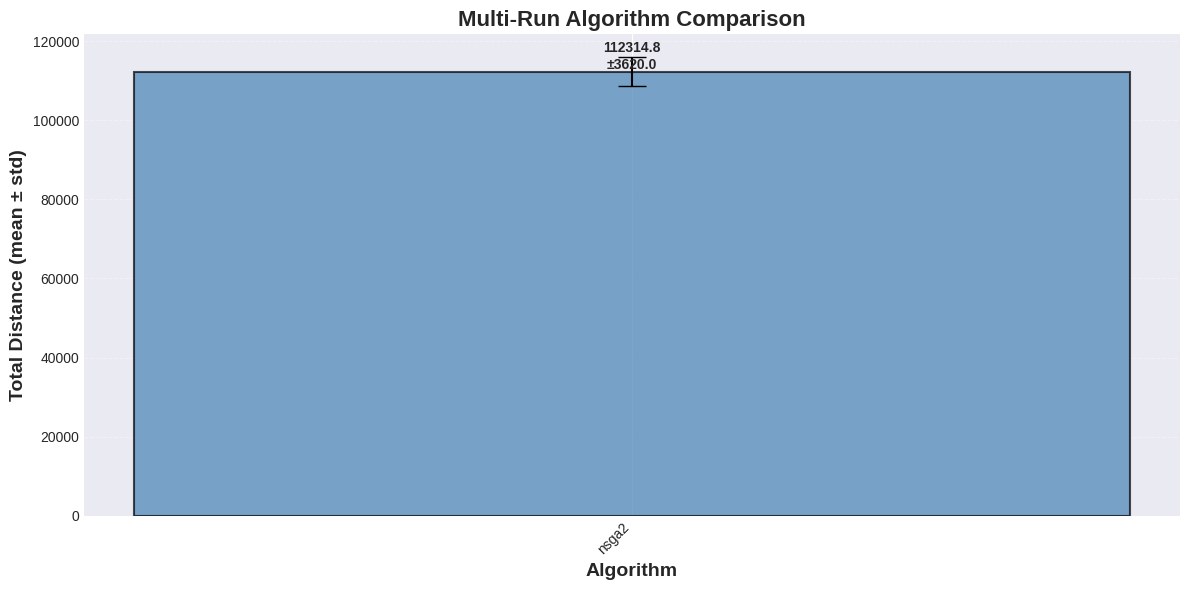

✓ Boxplot saved to: multirun_boxplot.png


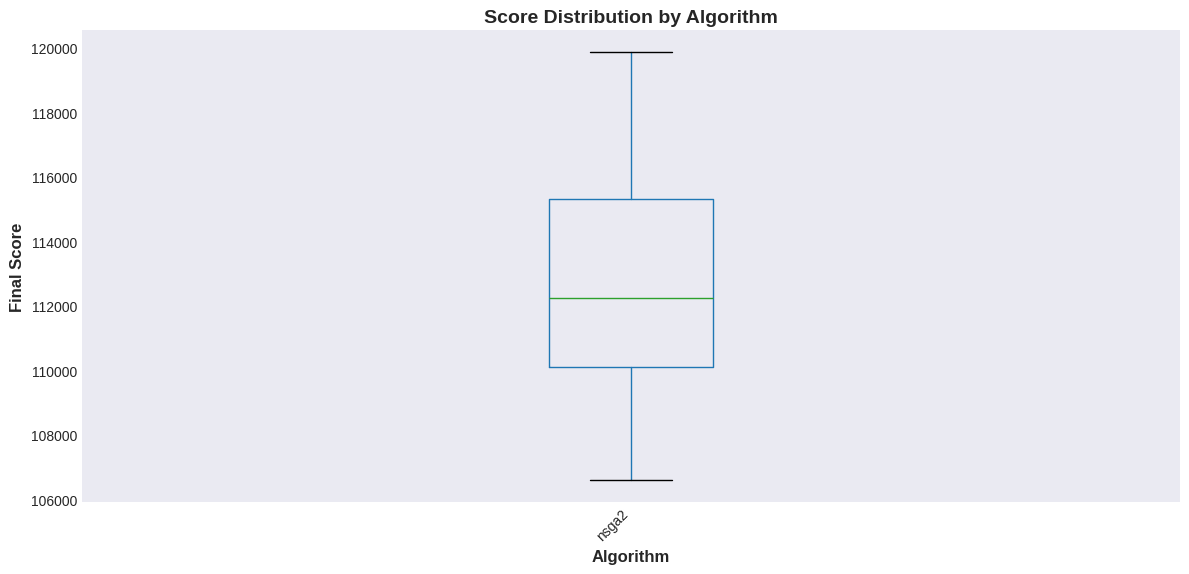

Analysis Complete!
Total runs analyzed: 30
Algorithms compared: 1

Output files:
  - multirun_statistics.csv
  - multirun_detailed.csv
  - multirun_analysis.png
  - multirun_boxplot.png


In [3]:
# Cell 1: Imports
import json
from pathlib import Path
from typing import Dict, List, Any
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Enable inline plotting
%matplotlib inline

# Styling
plt.style.use('seaborn-v0_8-darkgrid')
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

# ============================================================

# Cell 2: Configuration
RESULTS_BASE_DIR = Path("results/GIB_MULTIRUN")  # Base directory for multirun results
ALGOS = ["nsga2"]  # List of algorithms to analyze, e.g., ["nsga2", "ga", "pso"]
SCORER = "distance"  # "distance" or "cost"

print(f"Base directory: {RESULTS_BASE_DIR}")
print(f"Algorithms to analyze: {ALGOS}")
print(f"Using scorer: {SCORER}")

# ============================================================

# Cell 3: Collect All Runs
def collect_all_runs(base_dir: Path, algos: List[str]) -> pd.DataFrame:
    """
    Collect all run_summary_aggregated.json files from multirun directories.
    Returns DataFrame with columns: algorithm, run_index, final_score, output_dir
    """
    data = []
    
    # For each algorithm, find all run directories
    for algo in algos:
        pattern = f"{base_dir.name}_{algo}_run*"
        print(f"\nSearching for: {base_dir.parent / pattern}")
        
        for run_dir in base_dir.parent.glob(pattern):
            if not run_dir.is_dir():
                continue
            
            summary_file = run_dir / "run_summary_aggregated.json"
            if not summary_file.exists():
                print(f"  Warning: {summary_file} not found, skipping")
                continue
            
            with open(summary_file, "r") as f:
                summary = json.load(f)
            
            algorithm = summary.get("algorithm", algo)
            run_index = summary.get("run_index", 0)
            
            # Get the appropriate score based on scorer
            scorer = summary.get("scorer", SCORER)
            if scorer == "distance":
                final_score = summary.get("sum_final_distance", 0.0)
            elif scorer == "cost":
                final_score = summary.get("sum_final_cost", 0.0)
            else:
                final_score = summary.get("sum_final_distance", 0.0)
            
            data.append({
                "algorithm": algorithm,
                "config_name": summary.get("config_name", algorithm),
                "run_index": run_index,
                "final_score": final_score,
                "output_dir": str(run_dir),
                "clusters": summary.get("clusters", 0),
            })
            print(f"  ✓ Found run {run_index + 1}: score={final_score:.2f}")
    
    df = pd.DataFrame(data)
    print(f"\n{'='*60}")
    print(f"✓ Collected {len(df)} runs total")
    return df

# Collect data
df = collect_all_runs(RESULTS_BASE_DIR, ALGOS)

if df.empty:
    print("❌ No data found! Check RESULTS_BASE_DIR and ALGOS.")
else:
    print(f"\n✓ Found algorithms: {df['config_name'].unique().tolist()}")
    print(f"✓ Runs per algorithm:")
    print(df.groupby('config_name').size())

# ============================================================

# Cell 4: Preview Data
df.head(10)

# ============================================================

# Cell 5: Compute Statistics
def compute_statistics(df: pd.DataFrame) -> pd.DataFrame:
    """
    Compute mean and std for each algorithm/config.
    """
    stats = df.groupby("config_name")["final_score"].agg(
        mean="mean",
        std="std",
        count="count",
        min="min",
        max="max",
    ).reset_index()
    
    return stats

# Compute statistics
stats = compute_statistics(df)

print("="*60)
print("Statistics Summary")
print("="*60)
print(stats.to_string(index=False))

# Save to CSV
stats.to_csv("multirun_statistics.csv", index=False)
df.to_csv("multirun_detailed.csv", index=False)
print("\n✓ Saved: multirun_statistics.csv")
print("✓ Saved: multirun_detailed.csv")

# ============================================================

# Cell 6: Bar Chart with Error Bars
def plot_results(stats: pd.DataFrame, output_file: str = "multirun_analysis.png"):
    """
    Create bar chart with error bars showing mean ± std.
    """
    fig, ax = plt.subplots(figsize=(12, 6))
    
    x_pos = np.arange(len(stats))
    means = stats["mean"].values
    stds = stats["std"].values
    labels = stats["config_name"].values
    
    # Create bars
    bars = ax.bar(x_pos, means, yerr=stds, capsize=10, alpha=0.7, 
                   color='steelblue', edgecolor='black', linewidth=1.5)
    
    # Customize plot
    ax.set_xlabel("Algorithm", fontsize=14, fontweight='bold')
    ax.set_ylabel(f"Total Distance (mean ± std)", fontsize=14, fontweight='bold')
    ax.set_title("Multi-Run Algorithm Comparison", fontsize=16, fontweight='bold')
    ax.set_xticks(x_pos)
    ax.set_xticklabels(labels, rotation=45, ha='right')
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    
    # Add value labels on bars
    for i, (bar, mean, std) in enumerate(zip(bars, means, stds)):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{mean:.1f}\n±{std:.1f}',
                ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    plt.tight_layout()
    plt.savefig(output_file, dpi=300, bbox_inches='tight')
    print(f"✓ Plot saved to: {output_file}")
    plt.show()

# Create plot
plot_results(stats)

# ============================================================

# Cell 7: Box Plot Distribution
fig, ax = plt.subplots(figsize=(12, 6))

df.boxplot(column='final_score', by='config_name', ax=ax, grid=False)
ax.set_xlabel("Algorithm", fontsize=12, fontweight='bold')
ax.set_ylabel("Final Score", fontsize=12, fontweight='bold')
ax.set_title("Score Distribution by Algorithm", fontsize=14, fontweight='bold')
plt.suptitle("")  # Remove automatic title
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig("multirun_boxplot.png", dpi=300, bbox_inches='tight')
print("✓ Boxplot saved to: multirun_boxplot.png")
plt.show()

# ============================================================

# Cell 8: Summary
print("="*60)
print("Analysis Complete!")
print("="*60)
print(f"Total runs analyzed: {len(df)}")
print(f"Algorithms compared: {len(stats)}")
print("\nOutput files:")
print("  - multirun_statistics.csv")
print("  - multirun_detailed.csv")
print("  - multirun_analysis.png")
print("  - multirun_boxplot.png")
print("="*60)